In [14]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Mean
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
import time
from IPython import display
IMG_PATH = 'H:/3710_GAN/tensorflow_datasets'
# fix blast XGEMM failed
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [15]:
ds = tfds.load('celeb_a', split='train+test+validation', data_dir=IMG_PATH, shuffle_files=True, download=False)
len(ds)

202599

In [16]:
BATCH_SIZE = 32
ds = ds.batch(BATCH_SIZE)

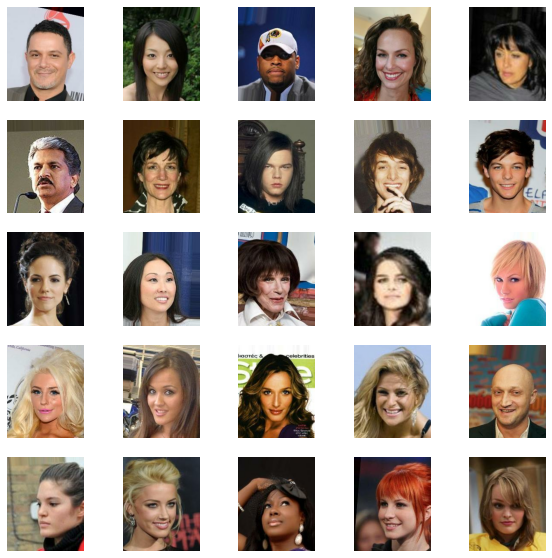

In [17]:
plt.figure(1, figsize=(10,10))

for example in ds:
    for i in range(25):
        plt.subplot(5,5,i+1)    # the number of images in the grid is 5*5 (25)
        plt.imshow(example["image"][i])
        plt.axis("off")
    plt.show()
    break

In [18]:
# resize image
def transform_images(row, size):
    x_train = tf.image.resize(row['image'], size)
    x_train = (x_train - 127.5)/127.5
    return x_train

ds = ds.map(lambda row:transform_images(row, (64, 64)))
ds

<MapDataset shapes: (None, 64, 64, 3), types: tf.float32>

In [19]:
ds = ds.shuffle(1024).prefetch(tf.data.experimental.AUTOTUNE)
ds

<PrefetchDataset shapes: (None, 64, 64, 3), types: tf.float32>

In [20]:
len(ds)

6332

In [4]:
DIS_RELU_ALPHA = 0.2
DROPOUT=0.2

dis = tf.keras.Sequential()
dis.add(layers.InputLayer(input_shape=(64, 64, 3)))
dis.add(layers.Conv2D(64, kernel_size=4, strides=2, padding="same"))
dis.add(layers.LeakyReLU(alpha=DIS_RELU_ALPHA))
dis.add(layers.Conv2D(128, kernel_size=4, strides=2, padding="same"))
dis.add(layers.LeakyReLU(alpha=DIS_RELU_ALPHA))
dis.add(layers.Conv2D(128, kernel_size=4, strides=2, padding="same"))
dis.add(layers.LeakyReLU(alpha=DIS_RELU_ALPHA))
dis.add(layers.Flatten())
dis.add(layers.Dropout(DROPOUT))
dis.add(layers.Dense(1, activation="sigmoid"))

dis.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         262272    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0

In [5]:
latent_dim = 128
GEN_RELU_ALPHA = 0.2

gen = tf.keras.Sequential()
gen.add(layers.InputLayer(input_shape=(latent_dim,)))
gen.add(layers.Dense(8*8*128))
gen.add(layers.Reshape((8, 8, 128)))
gen.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
gen.add(layers.LeakyReLU(alpha=GEN_RELU_ALPHA))
gen.add(layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"))
gen.add(layers.LeakyReLU(alpha=GEN_RELU_ALPHA))
gen.add(layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"))
gen.add(layers.LeakyReLU(alpha=GEN_RELU_ALPHA))
gen.add(layers.Conv2D(3, kernel_size=5, padding="same", activation="tanh"))

gen.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              1056768   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       524544    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 512)      

In [6]:
class GAN(tf.keras.Model):
    def __init__(self, dis, gen, latent_dim):
        super(GAN, self).__init__()
        self.dis = dis
        self.gen = gen
        self.latent_dim = latent_dim
        
    def compile(self, d_opt, g_opt, loss_fn):
        super(GAN, self).compile()
        self.d_opt = d_opt
        self.g_opt = g_opt
        self.loss_fn = loss_fn
        self.d_loss = Mean()
        self.g_loss = Mean()

    @property
    def metrics(self):
        return [self.d_loss, self.g_loss]

    def train_step(self, imgs):
        # Sample random noise in the latent space
        batch_size = tf.shape(imgs)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # fake image
        generated_images = self.gen(noise)

        # Combine with real imgs
        combined_images = tf.concat([generated_images, imgs], axis=0)

        # Make real and fake labels
        real_labels = tf.zeros((batch_size, 1))
        fake_labels = tf.ones((batch_size, 1))
        # fake = 1; real = 0
        labels = tf.concat([fake_labels, real_labels], axis=0)
        # label smoothing
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
    
        # Train the discriminator - try to differentiate between real and fake
        # Generator not trained here
        with tf.GradientTape() as tape:
            preds = self.dis(combined_images)
            # loss(true labels, pred labels)
            d_loss = self.loss_fn(labels, preds)
        grads = tape.gradient(d_loss, self.dis.trainable_weights)
        self.d_opt.apply_gradients(zip(grads, self.dis.trainable_weights))
 
        # Sample random points in the latent space
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))


        # Train the generator - try to fool the discriminator into classifying all real
        # Discriminator not trained here
        with tf.GradientTape() as tape:
            preds = self.dis(self.gen(noise))
            g_loss = self.loss_fn(real_labels, preds)
        grads = tape.gradient(g_loss, self.gen.trainable_weights)
        self.g_opt.apply_gradients(zip(grads, self.gen.trainable_weights))

        # Update d and g losses
        self.d_loss.update_state(d_loss)
        self.g_loss.update_state(g_loss)
        
        metric_dict = {"d_loss": self.d_loss.result(),"g_loss": self.g_loss.result()}
        return metric_dict

In [7]:
class GANCallback(tf.keras.callbacks.Callback):
    def __init__(self, ckpt, ckpt_manager, num_img=1, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.ckpt_manager = ckpt_manager
        self.ckpt = ckpt

    def on_epoch_end(self, epoch, logs=None):
        self.ckpt.start_epoch.assign_add(1)
        self.ckpt_manager.save() 
        if (epoch + 1) % 5 == 0:
            noise = tf.random.normal(shape=(self.num_img, latent_dim))
            generated_images = self.model.gen(noise)
            generated_images = (generated_images + 1) / 2. # convert back to [0, 1]
            generated_images = generated_images.numpy()
            
            plt.imshow(generated_images[0])
            plt.axis("off")
            plt.show()

In [8]:
epochs = 50

gan = GAN(dis=dis, gen=gen, latent_dim=latent_dim)
gan.compile(
    d_opt=Adam(learning_rate=0.0001),
    g_opt=Adam(learning_rate=0.0001),
    loss_fn=BinaryCrossentropy(),
)

checkpoint_dir = 'H:/3710_GAN/ckpt'

checkpoint = tf.train.Checkpoint(
    start_epoch=tf.Variable(1),
    gen=gen,
    dis=dis,
    gan=gan)

ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)
RETRAIN = True
START_EPOCH = 1
if RETRAIN:
    checkpoint.restore(ckpt_manager.latest_checkpoint)
    START_EPOCH = checkpoint.start_epoch.numpy()

print("Starting training from Epoch", START_EPOCH)

Starting training from Epoch 51


Epoch 1/50
6332/6332 [==============================] - 923s 144ms/step - d_loss: 0.5669 - g_loss: 1.3420
Epoch 2/50
6332/6332 [==============================] - 916s 144ms/step - d_loss: 0.6426 - g_loss: 1.0976
Epoch 3/50
6332/6332 [==============================] - 916s 144ms/step - d_loss: 0.6522 - g_loss: 1.0507
Epoch 4/50
6332/6332 [==============================] - 916s 144ms/step - d_loss: 0.6393 - g_loss: 1.0933
Epoch 5/50
6332/6332 [==============================] - 917s 144ms/step - d_loss: 0.6360 - g_loss: 1.0707


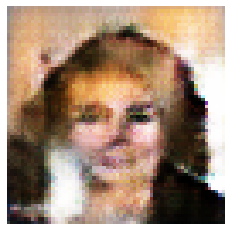

Epoch 6/50
6332/6332 [==============================] - 916s 144ms/step - d_loss: 0.6582 - g_loss: 1.0548
Epoch 7/50
6332/6332 [==============================] - 916s 144ms/step - d_loss: 0.6441 - g_loss: 0.9947
Epoch 8/50
6332/6332 [==============================] - 916s 144ms/step - d_loss: 0.6670 - g_loss: 0.9365
Epoch 9/50
6332/6332 [==============================] - 916s 144ms/step - d_loss: 0.6770 - g_loss: 0.9155
Epoch 10/50
6332/6332 [==============================] - 914s 144ms/step - d_loss: 0.6691 - g_loss: 0.9114


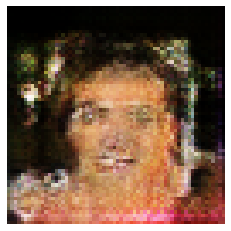

Epoch 11/50
6332/6332 [==============================] - 916s 144ms/step - d_loss: 0.6790 - g_loss: 0.9034
Epoch 12/50
6332/6332 [==============================] - 918s 145ms/step - d_loss: 0.6792 - g_loss: 0.9058
Epoch 13/50
6332/6332 [==============================] - 916s 144ms/step - d_loss: 0.6741 - g_loss: 0.8957
Epoch 14/50
6332/6332 [==============================] - 917s 144ms/step - d_loss: 0.6557 - g_loss: 0.9422
Epoch 15/50
6332/6332 [==============================] - 917s 144ms/step - d_loss: 0.6656 - g_loss: 0.9575


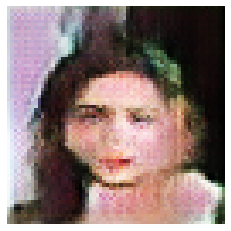

Epoch 16/50
6332/6332 [==============================] - 915s 144ms/step - d_loss: 0.6526 - g_loss: 0.9476
Epoch 17/50
6332/6332 [==============================] - 917s 144ms/step - d_loss: 0.6504 - g_loss: 0.9487
Epoch 18/50
6332/6332 [==============================] - 916s 144ms/step - d_loss: 0.6550 - g_loss: 0.9437
Epoch 19/50
6332/6332 [==============================] - 917s 144ms/step - d_loss: 0.6494 - g_loss: 0.9462
Epoch 20/50
6332/6332 [==============================] - 918s 145ms/step - d_loss: 0.6464 - g_loss: 0.9554


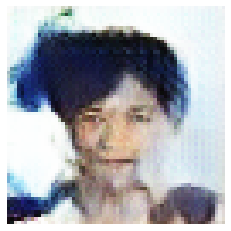

Epoch 21/50
6332/6332 [==============================] - 916s 144ms/step - d_loss: 0.6499 - g_loss: 0.9535
Epoch 22/50
6332/6332 [==============================] - 916s 144ms/step - d_loss: 0.6419 - g_loss: 0.9613
Epoch 23/50
6332/6332 [==============================] - 916s 144ms/step - d_loss: 0.6467 - g_loss: 0.9609
Epoch 24/50
6332/6332 [==============================] - 916s 144ms/step - d_loss: 0.6437 - g_loss: 0.9741
Epoch 25/50
6332/6332 [==============================] - 917s 144ms/step - d_loss: 0.6448 - g_loss: 0.9639


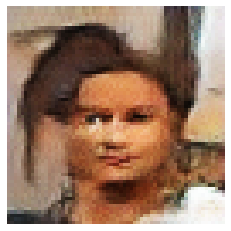

Epoch 26/50
6332/6332 [==============================] - 917s 144ms/step - d_loss: 0.6449 - g_loss: 0.9720
Epoch 27/50
6332/6332 [==============================] - 916s 144ms/step - d_loss: 0.6524 - g_loss: 0.9671
Epoch 28/50
6332/6332 [==============================] - 916s 144ms/step - d_loss: 0.6418 - g_loss: 0.9583
Epoch 29/50
6332/6332 [==============================] - 916s 144ms/step - d_loss: 0.6476 - g_loss: 0.9621
Epoch 30/50
6332/6332 [==============================] - 915s 144ms/step - d_loss: 0.6471 - g_loss: 0.9508


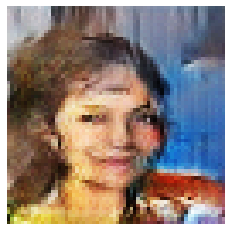

Epoch 31/50
6332/6332 [==============================] - 908s 143ms/step - d_loss: 0.6469 - g_loss: 0.9697
Epoch 32/50
6332/6332 [==============================] - 907s 143ms/step - d_loss: 0.6464 - g_loss: 0.9367
Epoch 33/50
6332/6332 [==============================] - 908s 143ms/step - d_loss: 0.6516 - g_loss: 0.9469
Epoch 34/50
6332/6332 [==============================] - 908s 143ms/step - d_loss: 0.6508 - g_loss: 0.9516
Epoch 35/50
6332/6332 [==============================] - 907s 143ms/step - d_loss: 0.6558 - g_loss: 0.9603


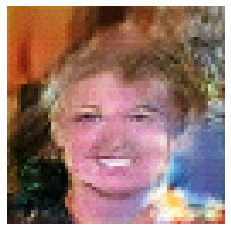

Epoch 36/50
6332/6332 [==============================] - 907s 143ms/step - d_loss: 0.6449 - g_loss: 0.9551
Epoch 37/50
6332/6332 [==============================] - 907s 143ms/step - d_loss: 0.6483 - g_loss: 0.9471
Epoch 38/50
6332/6332 [==============================] - 907s 143ms/step - d_loss: 0.6501 - g_loss: 0.9373
Epoch 39/50
6332/6332 [==============================] - 906s 143ms/step - d_loss: 0.6456 - g_loss: 0.9534
Epoch 40/50
6332/6332 [==============================] - 907s 143ms/step - d_loss: 0.6404 - g_loss: 0.9593


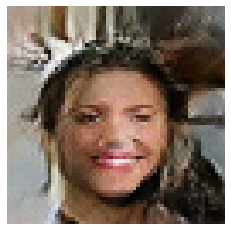

Epoch 41/50
6332/6332 [==============================] - 907s 143ms/step - d_loss: 0.6413 - g_loss: 0.9547
Epoch 42/50
6332/6332 [==============================] - 907s 143ms/step - d_loss: 0.6395 - g_loss: 0.9802
Epoch 43/50
6332/6332 [==============================] - 907s 143ms/step - d_loss: 0.6349 - g_loss: 0.9824
Epoch 44/50
6332/6332 [==============================] - 907s 143ms/step - d_loss: 0.6300 - g_loss: 0.9745
Epoch 45/50
6332/6332 [==============================] - 910s 143ms/step - d_loss: 0.6282 - g_loss: 0.9882


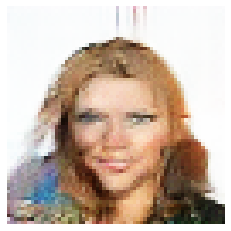

Epoch 46/50
6332/6332 [==============================] - 911s 143ms/step - d_loss: 0.6227 - g_loss: 1.0018
Epoch 47/50
6332/6332 [==============================] - 906s 143ms/step - d_loss: 0.6257 - g_loss: 0.9884
Epoch 48/50
6332/6332 [==============================] - 907s 143ms/step - d_loss: 0.6202 - g_loss: 1.0112
Epoch 49/50
6332/6332 [==============================] - 907s 143ms/step - d_loss: 0.6217 - g_loss: 1.0015
Epoch 50/50
6332/6332 [==============================] - 907s 143ms/step - d_loss: 0.6171 - g_loss: 1.0231


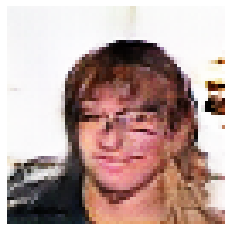

In [13]:
history = gan.fit(
    ds, epochs=epochs, callbacks=[GANCallback(checkpoint, ckpt_manager, num_img=1, latent_dim=latent_dim)]
)

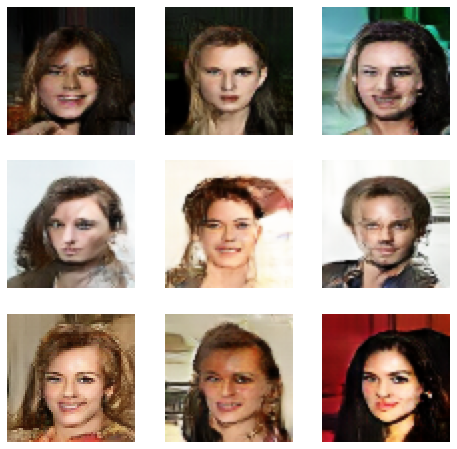

In [23]:
num_imgs = 9
noise = tf.random.normal(shape=(num_imgs, latent_dim))
generated_images = gen(noise)
generated_images = (generated_images + 1) / 2. # convert back to [0, 1]
generated_images = generated_images.numpy()
plt.figure(1, figsize=(8,8))
for i in range(num_imgs):
    plt.subplot(3,3,i+1) 
    plt.imshow(generated_images[i])
    plt.axis("off")
    img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
    img.save("generated_%d.png" % (i))
plt.show()